In [1]:
using FFTW
using WAV
using GLMakie

In [53]:
y, Fs, nbits, opts  = wavread("/Users/darwin/Downloads/Unknown-3.wav")

([0.00640888698995941; 0.0043641468550675985; … ; 0.0; 0.0;;], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [3]:
base_frequencies = [41.2, 55.0, 73.4, 98.0]
base_notes = ["E", "A", "D", "G"]
max_harmonics = 5

5

In [48]:
min_cycles = 20 # cycles
max_wait_time = 4 #seconds
min_window = Int(round((10/minimum(base_frequencies))*Fs))
max_window = Int(max_wait_time*Fs)

176400

In [7]:
function harmonic_energy(f_amplitudes, freq_bin, n_harmonics = 5)
    window = length(f_amplitudes)
    
    energy = 0.0
    for n in 1:n_harmonics
        bin = n*(freq_bin-1) + 1
        energy += abs(f_amplitudes[bin])
    end
    
    return energy
end

harmonic_energy (generic function with 2 methods)

In [12]:
freq_to_bin(f, window, Fs) = Int(round(f*window/Fs + 1))

freq_to_bin (generic function with 1 method)

In [16]:
function identify_pitch(input, options, Fs, n_harmonics, f_range)
    amplitudes = rfft(input)
    window = length(input)
    
    options_bins = freq_to_bin.(options, window, Fs)

    energies = harmonic_energy.(Ref(amplitudes), options_bins, n_harmonics)
    i = argmax(energies)

    resolution = Fs/length(input)
    bin_width = ceil(Int, f_range/resolution)
    center_bin = freq_to_bin(options[i], window, Fs)
    bins = center_bin-bin_width:center_bin+bin_width
    energies_hires = harmonic_energy.(Ref(amplitudes), bins, n_harmonics)
    j = argmax(energies_hires)
    
    return options[i], i, (bins[j] - 1)*Fs/window
end

identify_pitch (generic function with 1 method)

In [54]:
window = min_window
start = 1
identified_pitch = []
chunk = 1000
while start + window < length(y)
    y_sample = y[start:start+window]
    _, _, pitch = identify_pitch(y_sample, base_frequencies, Fs, 5, 5)
    push!(identified_pitch, pitch)
    if window < max_window
        window += chunk
    else
        start += chunk
    end
end

In [55]:
identified_pitch

848-element Vector{Any}:
  98.86969f0
  97.95814f0
 100.661156f0
  99.751915f0
  98.96634f0
  98.2808f0
 100.31727f0
  99.63287f0
  99.02165f0
  98.472466f0
  97.97633f0
  99.55771f0
  99.05748f0
   ⋮
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0
  41.428368f0

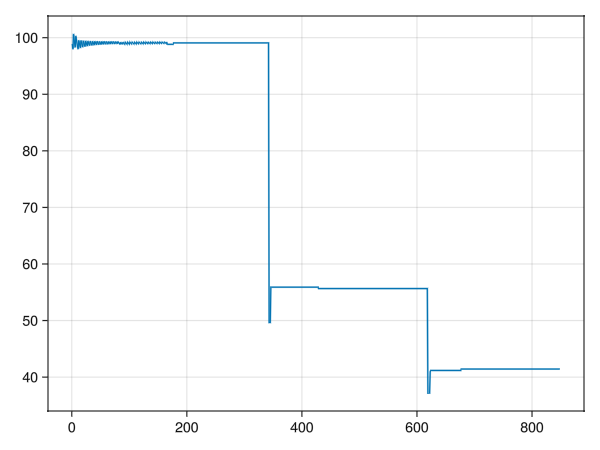

┌ Warning: error in renderloop
│   exception =
│    InterruptException:
│    Stacktrace:
│      [1] poptask(W::Base.IntrusiveLinkedListSynchronized{Task})
│        @ Base ./task.jl:999
│      [2] wait()
│        @ Base ./task.jl:1008
│      [3] wait(c::Base.GenericCondition{Base.Threads.SpinLock}; first::Bool)
│        @ Base ./condition.jl:130
│      [4] wait
│        @ ./condition.jl:125 [inlined]
│      [5] _trywait(t::Timer)
│        @ Base ./asyncevent.jl:142
│      [6] wait
│        @ ./asyncevent.jl:159 [inlined]
│      [7] sleep(sec::Float64)
│        @ Base ./asyncevent.jl:265
│      [8] sleep(timer::Makie.BudgetedTimer)
│        @ Makie ~/.julia/packages/Makie/Y3ABD/src/utilities/timing.jl:120
│      [9] on_demand_renderloop(screen::GLMakie.Screen{GLFW.Window})
│        @ GLMakie ~/.julia/packages/GLMakie/TH3rf/src/screen.jl:946
│     [10] renderloop(screen::GLMakie.Screen{GLFW.Window})
│        @ GLMakie ~/.julia/packages/GLMakie/TH3rf/src/screen.jl:963
│     [11] (::GLMakie

In [56]:
lines(identified_pitch)